In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# from warnings import filterwarnings
# filterwarnings(action='ignore')

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import evalys
from evalys.jobset import JobSet

In [2]:
input_location = 'KTH-alloc-only-filter'
files_prefix = ''
# schedule_names = ['filler', 'balance-largest-1', 'balance-smallest-1', 'balance-ratio-1', 'backfill-1', 'no-reserve-1', 'fcfs']
schedule_names = ['filler', 'backfill-1', 'no-future-1', 'fcfs']

In [3]:
schedule_files = []
jobs_files = []
for file in os.listdir('../output/' + input_location):
    if file.endswith('_schedule.csv'):
        schedule_files.append(file)
    elif file.endswith('_jobs.csv'):
        jobs_files.append(file)

schedule_files = [os.path.join('../output', input_location, str(file)) for file in sorted(schedule_files)]
jobs_files = [os.path.join('../output', input_location, str(file)) for file in sorted(jobs_files)]
print(schedule_files)
print(jobs_files)

['../output/KTH-alloc-only-filter/backfill-1_schedule.csv', '../output/KTH-alloc-only-filter/backfill-sjf-1_schedule.csv', '../output/KTH-alloc-only-filter/fcfs_schedule.csv', '../output/KTH-alloc-only-filter/filler_schedule.csv', '../output/KTH-alloc-only-filter/no-future-1_schedule.csv']
['../output/KTH-alloc-only-filter/backfill-1_jobs.csv', '../output/KTH-alloc-only-filter/backfill-sjf-1_jobs.csv', '../output/KTH-alloc-only-filter/fcfs_jobs.csv', '../output/KTH-alloc-only-filter/filler_jobs.csv', '../output/KTH-alloc-only-filter/no-future-1_jobs.csv']


In [4]:
metrics = pd.DataFrame()
for file in schedule_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        df = pd.read_csv(file)
        df['schedule'] = schedule_name
        df = df.set_index('schedule')
        metrics = metrics.append(df)

 backfill-1
 fcfs
 filler
 no-future-1


In [5]:
jobsets = {}
for file in jobs_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        jobsets[schedule_name] = JobSet.from_csv(file)

 backfill-1
 fcfs
 filler
 no-future-1


In [6]:
metrics.index.rename(None, inplace=True)
metrics = metrics.reindex(schedule_names)
# sns.set_theme(context='talk', style='whitegrid')
sns.set_theme(style='whitegrid')

In [7]:
def calculate_compute_utilisation(schedule):
    compute_time = jobsets[schedule].df[['execution_time', 'requested_number_of_resources']].apply(lambda row: row.execution_time * row.requested_number_of_resources, axis=1).sum()
    return compute_time / (metrics.loc[schedule].makespan * 96)

def calculate_storage_utilisation(schedule):
    storage_time = jobsets[schedule].df[['execution_time', 'metadata']].apply(lambda row: row.execution_time * row.metadata, axis=1).sum()
    burst_buffer_capacity = 5 * 10**9
    num_burst_buffers = 12
    total_storage_time = metrics.loc[schedule].makespan * num_burst_buffers * burst_buffer_capacity
    return storage_time / total_storage_time

def create_metric_df(metric):
    return pd.concat([jobsets[schedule].df[metric].rename(schedule) for schedule in schedule_names], axis=1)

In [8]:
def bounded_slowdown(df):
    return (df.turnaround_time / df.execution_time.clip(lower=600)).clip(lower=1)

def create_all_metrics_df():
    dfs = []
    for schedule in schedule_names:
        df = jobsets[schedule].df
        df = df.assign(schedule=schedule).assign(bounded_slowdown=bounded_slowdown(df))[['schedule', 'waiting_time', 'turnaround_time', 'stretch', 'bounded_slowdown']]
        dfs.append(df)
    return pd.concat(dfs, axis=0)

In [9]:
def storage_queue(js):
    df = js.df.assign(total_storage=js.df.metadata * js.df.requested_number_of_resources)
    return evalys.metrics.compute_load(df, 'submission_time', 'starting_time', 'total_storage')

In [10]:
metrics['compute_utilisation'] = pd.Series({schedule: calculate_compute_utilisation(schedule) for schedule in schedule_names})
metrics['storage_utilisation'] = pd.Series({schedule: calculate_storage_utilisation(schedule) for schedule in schedule_names})

In [11]:
metrics.T

,filler,backfill-1,no-future-1,fcfs
batsim_version,4.0.0,4.0.0,4.0.0,4.0.0
consumed_joules,0,0,0,0
makespan,2.88682e+07,2.87948e+07,5.21539e+07,3.83624e+07
max_slowdown,475646,197917,1.89025e+07,9.50013e+06
max_turnaround_time,7.34032e+06,622412,4.33168e+07,9.74565e+06
max_waiting_time,7.33454e+06,508076,4.33168e+07,9.69732e+06
mean_slowdown,282.746,260.186,118922,151442
mean_turnaround_time,32405.5,23637.3,5.51596e+06,5.77052e+06
mean_waiting_time,23552.3,14784.1,5.50711e+06,5.76167e+06
nb_computing_machines,109,109,109,109


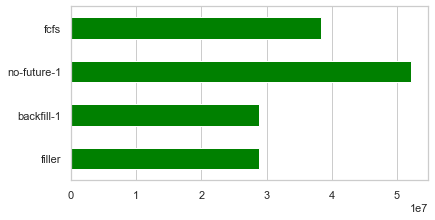

In [12]:
# ax = metrics['makespan'].plot.barh(figsize=(12, 8))
ax = metrics['makespan'].plot.barh(color='green', figsize=(6.4,3.2))
ax.grid(axis='y')
plt.savefig('../../images/results/reservation_alloc-only_makespan.pdf', bbox_inches='tight')

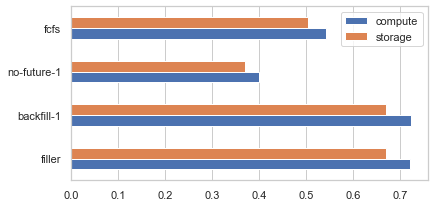

In [13]:
# ax = metrics[['compute_utilisation', 'storage_utilisation']].plot.barh(figsize=(14, 8))
ax = metrics[['compute_utilisation', 'storage_utilisation']].plot.barh(figsize=(6.4,3.2))
ax.legend(['compute', 'storage'])
ax.grid(axis='y')
plt.savefig('../../images/results/reservation_alloc-only_utilisation.pdf', bbox_inches='tight')

In [14]:
metrics_df = create_all_metrics_df()

In [15]:
waiting_times = create_metric_df('waiting_time')
waiting_times.describe()

,filler,backfill-1,no-future-1,fcfs
count,2.845300e+04,28453.000000,2.845300e+04,2.845300e+04
mean,2.356393e+04,14791.352665,5.509821e+06,5.764506e+06
std,1.879258e+05,40211.832803,9.346995e+06,2.899592e+06
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000,6.388001e+04,3.256030e+06
50%,0.000000e+00,37.001450,3.651165e+05,6.364812e+06
75%,4.720001e+03,9929.959092,6.903855e+06,8.262594e+06
max,7.334536e+06,508076.001850,4.331675e+07,9.697318e+06


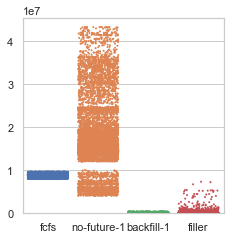

In [106]:
# Scatterplot, outliers
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'waiting_time']].nlargest(n=8000, columns='waiting_time') for schedule in schedule_names])
# fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(3.6,3.6))
sns.stripplot(data=largest, x='schedule', y='waiting_time', ax=ax, order=['fcfs', 'no-future-1', 'backfill-1', 'filler'], size=2, jitter=0.4)
# sns.stripplot(data=waiting_times, ax=ax, order=['fcfs', 'no-future-1', 'backfill-1', 'filler'], size=2, jitter=0.4)
ax.set_ylim(0)
# ax.set_ylim(top=4.5*10**7)
ax.set_ylabel('')
ax.set_xlabel('')
# fig.savefig('../../images/results/reservation_alloc-only_waiting-time_dist.png', bbox_inches='tight', dpi=600)
fig.savefig('../../images/results/reservation_alloc-only_waiting-time_dist.pdf', bbox_inches='tight')

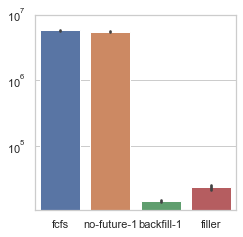

In [25]:
# Mean, logscale
# fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(3.6,3.6))
sns.barplot(data=waiting_times, ax=ax, order=['fcfs', 'no-future-1', 'backfill-1', 'filler'])
ax.set_yscale('log')
ax.set_ylim(top=10**7)
fig.savefig('../../images/results/reservation_alloc-only_waiting-time_mean.pdf', bbox_inches='tight')

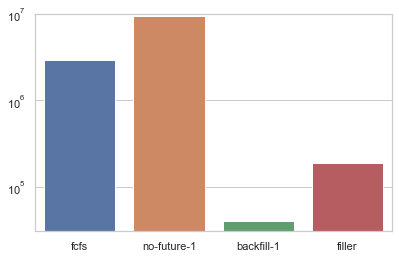

In [53]:
# Standard deviation, logscale
# fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(3.6,3.6))
sns.barplot(data=waiting_times, estimator=np.std, ci=None, ax=ax, order=['fcfs', 'no-future-1', 'backfill-1', 'filler'])
ax.set_yscale('log')
ax.set_ylim(top=10**7)
fig.savefig('../../images/results/reservation_alloc-only_waiting-time_std.pdf', bbox_inches='tight')

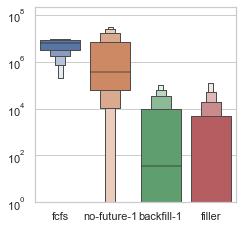

In [49]:
# Boxenplot
# fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(3.6,3.6))
sns.boxenplot(data=waiting_times, k_depth=4, showfliers=False, ax=ax, order=['fcfs', 'no-future-1', 'backfill-1', 'filler'])
ax.set_yscale('log')
ax.set_ylim(1)
fig.savefig('../../images/results/reservation_alloc-only_waiting-time_boxen.pdf', bbox_inches='tight')

In [23]:
turnaround_times = create_metric_df('turnaround_time')
turnaround_times.describe()

,filler,backfill-1,no-future-1,fcfs
count,2.845300e+04,28453.000000,2.845300e+04,2.845300e+04
mean,3.242149e+04,23648.927217,5.518678e+06,5.773364e+06
std,1.890215e+05,47445.607468,9.348145e+06,2.900782e+06
min,1.000000e+00,1.000000,1.000000e+00,2.000200e+00
25%,2.410002e+02,271.000200,7.293790e+04,3.269762e+06
50%,5.068003e+03,6278.000400,3.748320e+05,6.367625e+06
75%,1.989400e+04,25963.224819,6.914028e+06,8.271245e+06
max,7.340324e+06,622411.957392,4.331682e+07,9.745650e+06


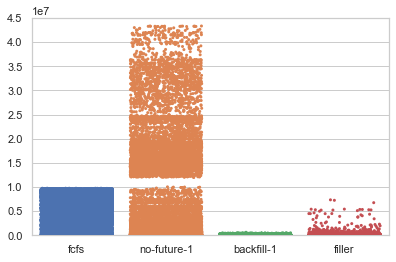

In [55]:
# Scatterplot, outliers
# fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(3.6,3.6))
sns.stripplot(data=turnaround_times, ax=ax, order=['fcfs', 'no-future-1', 'backfill-1', 'filler'], size=3, jitter=0.4)
ax.set_ylim(0)
ax.set_ylim(top=4.5*10**7)
fig.savefig('../../images/results/reservation_alloc-only_turnaround-time_dist.png', bbox_inches='tight', dpi=600)

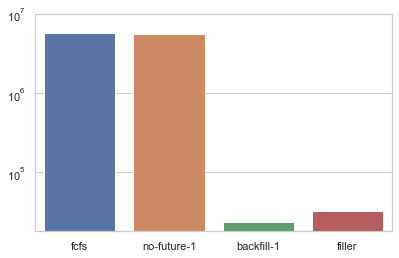

In [25]:
# Mean, logscale
# fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(3.6,3.6))
sns.barplot(data=turnaround_times, ci=None, ax=ax, order=['fcfs', 'no-future-1', 'backfill-1', 'filler'])
ax.set_yscale('log')
ax.set_ylim(top=10**7)
fig.savefig('../../images/results/reservation_alloc-only_turnaround-time_mean.pdf', bbox_inches='tight')

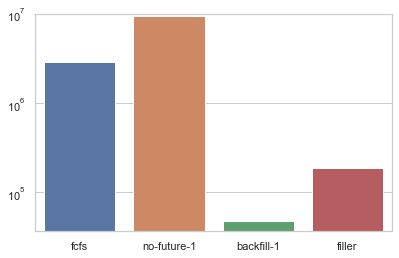

In [26]:
# Standard deviation, logscale
# fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(3.6,3.6))
sns.barplot(data=turnaround_times, estimator=np.std, ci=None, ax=ax, order=['fcfs', 'no-future-1', 'backfill-1', 'filler'])
ax.set_yscale('log')
ax.set_ylim(top=10**7)
fig.savefig('../../images/results/reservation_alloc-only_turnaround-time_std.pdf', bbox_inches='tight')

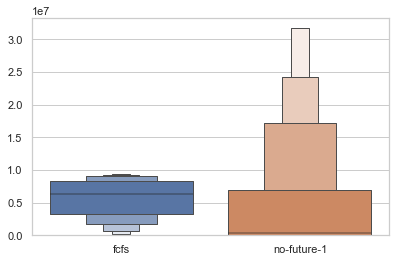

In [27]:
# Boxenplot
# fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(3.6,3.6))
sns.boxenplot(data=turnaround_times, k_depth=4, showfliers=False, ax=ax, order=['fcfs', 'no-future-1'])
ax.set_ylim(0)
fig.savefig('../../images/results/reservation_alloc-only_turnaround-time_boxen.pdf', bbox_inches='tight')

In [28]:
slowdown = create_metric_df('stretch')
slowdown.describe()

,filler,backfill-1,no-future-1,fcfs
count,28453.000000,28453.000000,2.845300e+04,2.845300e+04
mean,282.885224,260.313777,1.189805e+05,1.515163e+05
std,4159.753996,2535.926572,7.867079e+05,5.408354e+05
min,1.000000,1.000000,1.000000e+00,1.000000e+00
25%,1.000000,1.000000,2.306172e+01,5.798446e+02
50%,1.000000,1.022040,8.635444e+02,5.192225e+03
75%,4.559608,6.494006,1.070059e+04,9.815587e+04
max,475646.375649,197917.144035,1.890255e+07,9.500134e+06


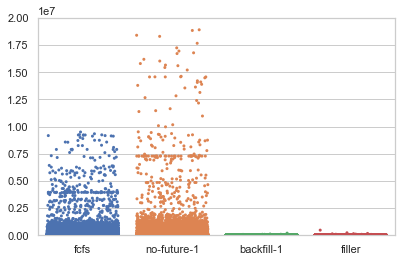

In [59]:
# Scatterplot, outliers
# fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(3.6,3.6))
sns.stripplot(data=slowdown, ax=ax, order=['fcfs', 'no-future-1', 'backfill-1', 'filler'], size=3, jitter=0.4)
ax.set_ylim(0)
ax.set_ylim(top=2*10**7)
fig.savefig('../../images/results/reservation_alloc-only_slowdown_dist.png', bbox_inches='tight', dpi=600)

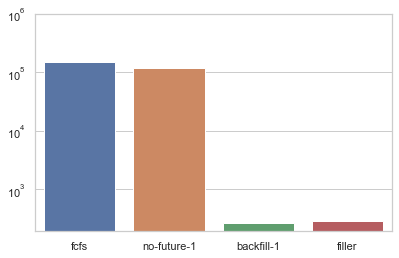

In [30]:
# Mean, logscale
# fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(3.6,3.6))
sns.barplot(data=slowdown, ci=None, ax=ax, order=['fcfs', 'no-future-1', 'backfill-1', 'filler'])
ax.set_yscale('log')
ax.set_ylim(top=10**6)
fig.savefig('../../images/results/reservation_alloc-only_slowdown_mean.pdf', bbox_inches='tight')

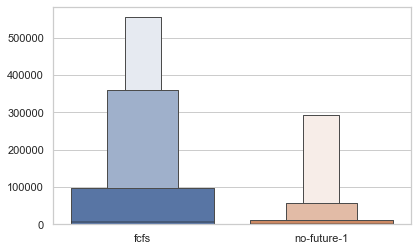

In [32]:
# Boxenplot
# fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(6.4,4))
sns.boxenplot(data=slowdown, k_depth=3, showfliers=False, ax=ax, order=['fcfs', 'no-future-1'])
ax.set_ylim(0)
fig.savefig('../../images/results/reservation_alloc-only_slowdown_boxen.pdf', bbox_inches='tight')

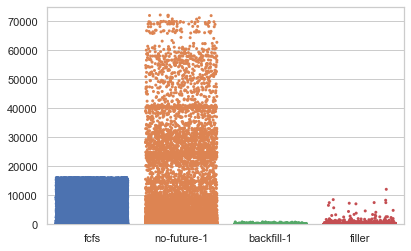

In [64]:
# Scatterplot, outliers
fig, ax = plt.subplots(figsize=(6.4,4))
sns.stripplot(data=metrics_df, x='schedule', y='bounded_slowdown', ax=ax, order=['fcfs', 'no-future-1', 'backfill-1', 'filler'], size=3, jitter=0.4)
ax.set_ylim(0)
ax.set_ylim(top=75000)
ax.set_ylabel('')    
ax.set_xlabel('')
fig.savefig('../../images/results/reservation_alloc-only_bounded-slowdown_dist.png', bbox_inches='tight', dpi=600)

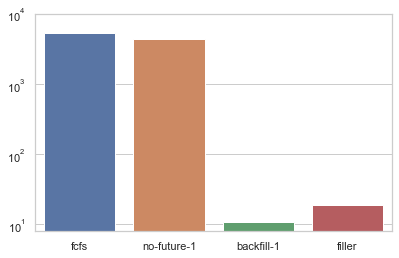

In [34]:
# Mean, logscale
# fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(6.4,4))
sns.barplot(data=metrics_df, x='schedule', y='bounded_slowdown', ci=None, ax=ax, order=['fcfs', 'no-future-1', 'backfill-1', 'filler'])
ax.set_yscale('log')
ax.set_ylim(top=10**4)
ax.set_ylabel('')    
ax.set_xlabel('')
fig.savefig('../../images/results/reservation_alloc-only_bounded-slowdown_mean.pdf', bbox_inches='tight')

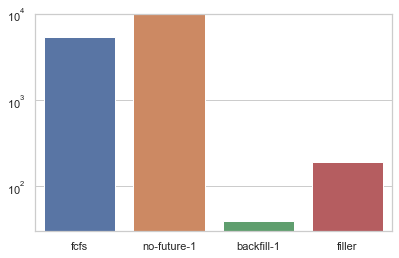

In [35]:
# Standard deviation, logscale
# fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(6.4,4))
sns.barplot(data=metrics_df, x='schedule', y='bounded_slowdown', estimator=np.std, ci=None, ax=ax, order=['fcfs', 'no-future-1', 'backfill-1', 'filler'])
ax.set_yscale('log')
ax.set_ylim(top=10**4)
ax.set_ylabel('')    
ax.set_xlabel('')
fig.savefig('../../images/results/reservation_alloc-only_bounded-slowdown_std.pdf', bbox_inches='tight')

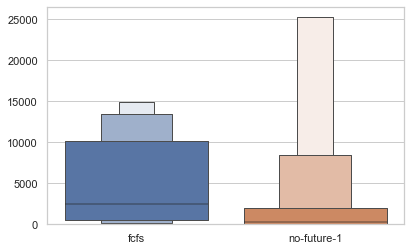

In [36]:
# Boxenplot
# fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(6.4,4))
sns.boxenplot(data=metrics_df, x='schedule', y='bounded_slowdown', k_depth=3, showfliers=False, ax=ax, order=['fcfs', 'no-future-1'])
ax.set_ylim(0)
ax.set_ylabel('')    
ax.set_xlabel('')
fig.savefig('../../images/results/reservation_alloc-only_bounded-slowdown_boxen.pdf', bbox_inches='tight')

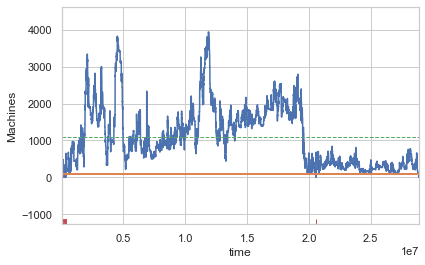

In [38]:
# fig, ax = plt.subplots(figsize=(20,8))
fig, ax = plt.subplots(figsize=(6.4,4))
evalys.visu.legacy.plot_load(jobsets['filler'].queue, nb_resources=96, ax=ax)
ax.get_legend().remove()
fig.savefig('../../images/results/reservation_alloc-only_compute-load_filler.pdf', bbox_inches='tight')

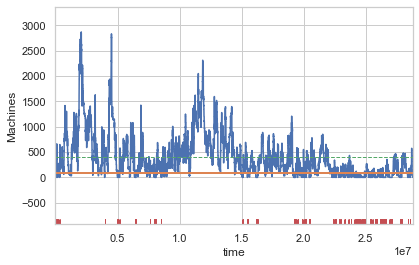

In [39]:
# fig, ax = plt.subplots(figsize=(20,8))
fig, ax = plt.subplots(figsize=(6.4,4))
evalys.visu.legacy.plot_load(jobsets['backfill-1'].queue, nb_resources=96, ax=ax)
ax.get_legend().remove()
fig.savefig('../../images/results/reservation_alloc-only_compute-load_backfill.pdf', bbox_inches='tight')

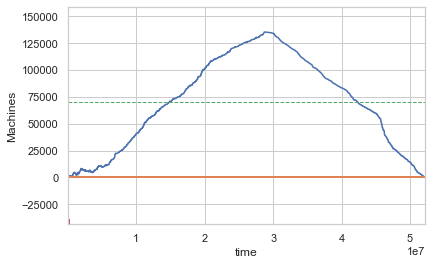

In [40]:
# fig, ax = plt.subplots(figsize=(20,8))
fig, ax = plt.subplots(figsize=(6.4,4))
evalys.visu.legacy.plot_load(jobsets['no-future-1'].queue, nb_resources=96, ax=ax)
ax.get_legend().remove()
fig.savefig('../../images/results/reservation_alloc-only_compute-load_future.pdf', bbox_inches='tight')

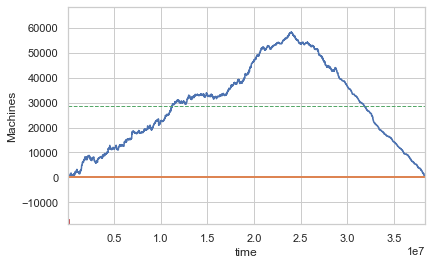

In [41]:
# fig, ax = plt.subplots(figsize=(20,8))
fig, ax = plt.subplots(figsize=(6.4,4))
evalys.visu.legacy.plot_load(jobsets['fcfs'].queue, nb_resources=96, ax=ax)
ax.get_legend().remove()
fig.savefig('../../images/results/reservation_alloc-only_compute-load_fcfs.pdf', bbox_inches='tight')

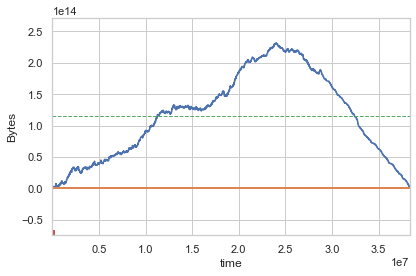

In [42]:
fig, ax = plt.subplots(figsize=(6.4,4))
evalys.visu.legacy.plot_load(storage_queue(jobsets['fcfs']), 480000000000)
ax.get_legend().remove()
ax.set_ylabel('Bytes')
fig.savefig('../../images/results/reservation_alloc-only_storage-load_fcfs.pdf', bbox_inches='tight')

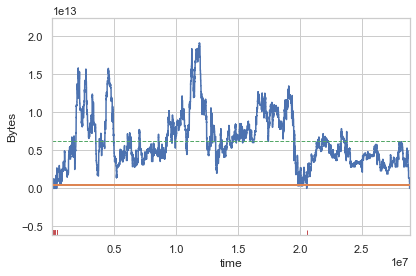

In [43]:
fig, ax = plt.subplots(figsize=(6.4,4))
evalys.visu.legacy.plot_load(storage_queue(jobsets['filler']), 480000000000)
ax.get_legend().remove()
ax.set_ylabel('Bytes')
fig.savefig('../../images/results/reservation_alloc-only_storage-load_filler.pdf', bbox_inches='tight')

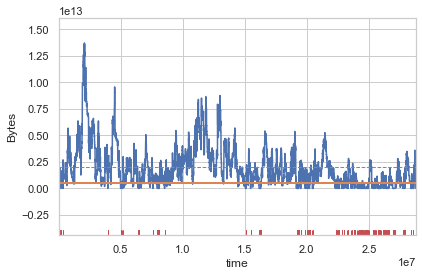

In [44]:
fig, ax = plt.subplots(figsize=(6.4,4))
evalys.visu.legacy.plot_load(storage_queue(jobsets['backfill-1']), 480000000000)
ax.get_legend().remove()
ax.set_ylabel('Bytes')
fig.savefig('../../images/results/reservation_alloc-only_storage-load_backfill.pdf', bbox_inches='tight')

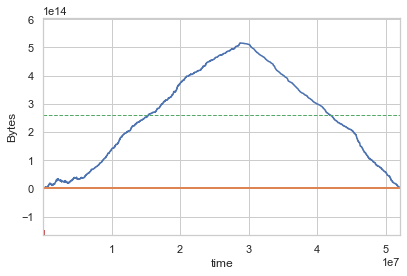

In [45]:
fig, ax = plt.subplots(figsize=(6.4,4))
evalys.visu.legacy.plot_load(storage_queue(jobsets['no-future-1']), 480000000000)
ax.get_legend().remove()
ax.set_ylabel('Bytes')
fig.savefig('../../images/results/reservation_alloc-only_storage-load_future.pdf', bbox_inches='tight')